In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from torch.utils.data import Dataset
import torchvision.models as models
from PIL import Image

In [2]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3080 (UUID: GPU-04199b69-af8a-9287-0d66-bbc964a5fc57)


In [3]:
from scripts.serverside.captcha.image import ImageCaptcha
from tqdm import tqdm
import os
import string
import random
import gc

In [4]:
def get_random_string(length):
    # choose from all lowercase letter
    letters = "abcdefghjkmnpqrstuvwxyz" + "ABCDEFGHIJKLMNPQRSTUVWXYZ" + "23456789" + "     "
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

In [5]:
from torchvision.transforms.transforms import Grayscale
# Load datasets
# Label formated as 2D tensor of indexed as [place][tokenID]
chars = "abcdefghijklmnpqrstuvwxyz123456789 " # use " " as null character. Leave out o and 0, also case insensitive
charIndex = {}
for i, char in enumerate(chars):
    charIndex[char] = i

idn = torch.eye(len(chars)).cuda()

def strToOH(string):
    oneHot = []
    for char in string:
        oneHot.append(idn[charIndex[char]])
    return torch.stack(oneHot)

def strToInd(string):
    oneHot = []
    for char in string:
        oneHot.append(torch.tensor(charIndex[char]))
    return torch.stack(oneHot)

In [6]:
do_cuda = True
os.environ["PYTORCH_CUDA_ALLOC_CONF"]="max_split_size_mb:128"
torch.cuda.empty_cache()

In [7]:
def get_accuracy(model, data_loader=None, denoise=False, train=False, batch_size = 64):
    if train:
        data = captchaPreProcLarge
    else:
        data = TrawSetVal #TODO: seperate validation set

    correct = 0
    total = 0
    if data_loader is None:
        data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    for imgs, labels, filtered in data_loader :

        if do_cuda and torch.cuda.is_available:
            imgs = imgs.cuda()
            labels = labels.cuda()
            filtered = filtered.cuda()
        
        with torch.no_grad():            
            if denoise:
                output = model(filtered)
            else:
                output = model(imgs, filtered)
                
        for i in range(imgs.shape[0]):
            #select index with maximum prediction score
            out = output[i, :, :]
            #print(out.shape)
            #print(digit.shape)
            pred = out.max(0, keepdim=True)[1]
            pred = pred.squeeze()
            #print(pred.shape)
            #print(labels[:, i].shape)
            #print(labels[i, :].shape)
            #print(pred.shape)
            correct += int(pred.eq(labels[i, :]).sum().item() == 8)
            total += 1
    torch.cuda.empty_cache()
    gc.collect()
    return correct / total

def train(model, data, batch_size=64, num_epochs=30, from_epoch=0, learning_rate=0.0001):
  #  train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    train_loader = None
    val_loader = torch.utils.data.DataLoader(TrawSetVal, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []


    startTime = time.time() # to see how long training goes
    print("starting training")
    # training
    n = 0 # the number of iterations
    for epoch in range(from_epoch, from_epoch+num_epochs):
        
        try:
            del train_loader
            torch.cuda.empty_cache()
            gc.collect()
            data.flush()
            train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        except Exception:
            pass
        print("epoch: ", epoch)
        for imgs, labels, filtered in iter(train_loader):

            if do_cuda and torch.cuda.is_available:
                imgs = imgs.cuda()
                labels = labels.cuda()
                filtered = filtered.cuda()

            out = model(imgs, filtered)             # forward pass
            #print(out[0])
            #print()
            #print(labels[0])
            #print()
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(loss.item()/batch_size)             # compute *average* loss
            n += 1

        #train_acc.append(get_accuracy(model, train=True, batch_size=batch_size)) # compute training accuracy 
        val_acc.append(get_accuracy(model, val_loader, train=False, batch_size=batch_size))  # compute validation accuracy
        print(("Epoch {}: |"+"Validation acc: {}").format(
                epoch, # call epoch zero epoch zero
                
                val_acc[-1]))
        
        #checkpoint
        path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
        torch.save(model.state_dict(), path)


  # np.savetxt(path+f"/tacc_{from_epoch+1}_to_{from_epoch+num_epochs}.csv", 
   #             val_acc,
   #             delimiter =", ", 
    #            fmt ='% s')
    
    finishTime = time.time()

    delta = finishTime - startTime
    print("\nDONE TRAINING in %s seconds!\n" % delta)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
   # plt.savefig(f"/loss_e{from_epoch+num_epochs}_{path}.jpg")

    plt.figure()
    plt.title("Training Curve")
    #plt.plot(range(num_epochs), train_acc, label="Train")
    plt.plot(range(num_epochs), val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()
 #   plt.savefig(f"/acc_e{from_epoch+num_epochs}_{path}_{val_acc[-1]}.jpg")

    #print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [8]:
import run_denoiser, copy
class DCacheSet():
    def __init__(self, size, period):
        self.size = size
        self.cached = []
        self.period = period
        self.IC = ImageCaptcha()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
       # self.flush()
    def flush(self):
        self.cached.clear()
        torch.cuda.empty_cache()
        gc.collect()        
        for index in range(self.period):
            label = get_random_string(8)
            data = self.IC.generate_image(label)
            data2 = run_denoiser.execute_pix2pix_denoise(global_denoising, copy.deepcopy(data))
            data = self.transform(data)
            data2 = self.transform(data2)
            label = label.lower().replace(" ", "")
            label += " " * (8 - len(label))

            labelTensor = strToInd(label)
            self.cached.append((data, labelTensor, data2))
    def __getitem__(self, index):
        index = index % self.period
        entry = self.cached[index]
        return entry[0], entry[1], entry[2]

    def __len__(self):
        return self.size

class DFrozenSet():
    def __init__(self, size):
        self.size = size
        self.cached = []
        self.period = size
        self.IC = ImageCaptcha()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.flush2()
    def flush2(self):
        self.cached.clear()
        for index in range(self.period):
            label = get_random_string(8)
            data = self.IC.generate_image(label)
            data2 = run_denoiser.execute_pix2pix_denoise(global_denoising, copy.deepcopy(data))
            data = self.transform(data)
            data2 = self.transform(data2)
            label = label.lower().replace(" ", "")
            label += " " * (8 - len(label))

            labelTensor = strToInd(label)
            self.cached.append((data, labelTensor, data2))
    def __getitem__(self, index):
        index = index % self.period
        entry = self.cached[index]
        return entry[0], entry[1], entry[2]

    def __len__(self):
        return self.size

In [9]:
class TCacheSet():
    def __init__(self, size, period):
        self.size = size
        self.cached = []
        self.period = period
        self.IC = ImageCaptcha()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.flush()
    def flush(self):
        self.cached.clear()
        for index in range(self.period):
            label = get_random_string(8)
            data = self.IC.generate_image(label)
            data = self.transform(data)
            label = label.lower().replace(" ", "")
            label += " " * (8 - len(label))

            labelTensor = strToInd(label)
            self.cached.append((data, labelTensor))
    def __getitem__(self, index):
        index = index % self.period
        entry = self.cached[index]
        return entry[0], entry[1], 0

    def __len__(self):
        return self.size

class TFrozenSet():
    def __init__(self, size):
        self.size = size
        self.cached = []
        self.period = size
        self.IC = ImageCaptcha()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.flush2()
    def flush2(self):
        self.cached.clear()
        for index in range(self.period):
            label = get_random_string(8)
            data = self.IC.generate_image(label)
            data = self.transform(data)
            label = label.lower().replace(" ", "")
            label += " " * (8 - len(label))

            labelTensor = strToInd(label)
            self.cached.append((data, labelTensor))
    def __getitem__(self, index):
        index = index % self.period
        entry = self.cached[index]
        return entry[0], entry[1], 0

    def __len__(self):
        return self.size

class TransferCaptcha(nn.Module):
    def __init__(self):
        super(TransferCaptcha, self).__init__()
        self.name = "TransferCaptcha"
        conv = models.resnext50_32x4d(pretrained=True)
        self.conv = conv
        self.layer1 = nn.Linear(1000, 512)
        self.layer2 = nn.Linear(512, len(chars) * 8)
      
    def forward(self, x, x2=0):
        
        x = self.conv(x)

        x = x.view(-1, 1000) # flatten convolution output for ANN
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        x = x.view(-1, len(chars), 8)
        #x = x.squeeze(1) # Flatten to [batch_size]
        return x  

class ViTCaptcha(nn.Module):
    def __init__(self):
        super(ViTCaptcha, self).__init__()
        self.name = "TransferCaptchaViT"
        self.enc = models.vit_b_32(pretrained=True)
        self.layer1 = nn.Linear(1000, len(chars) * 8)
      
    def forward(self, x, x2=0):
        
        x = self.enc(x)

        x = x.view(-1, 1000) # flatten enc output for ANN
        x = self.layer1(F.relu(x))
        x = x.view(-1, len(chars), 8)
        #x = x.squeeze(1) # Flatten to [batch_size]
        return x  

In [10]:
class ECaptcha2(nn.Module):
    def __init__(self):
        super(ECaptcha2, self).__init__()
        self.name = "ETransferCaptcha2"
        self.VIT = ViTCaptcha()
        self.CONV = TransferCaptcha()
        self.VIT2 = ViTCaptcha()
        self.CONV2 = TransferCaptcha()
        self.VIT.requires_grad = False
        self.CONV.requires_grad = False
        self.VIT2.requires_grad = False
        self.CONV2.requires_grad = False

        self.ensembler1 = nn.Linear(len(chars) * 8 * 4, len(chars) * 8 * 4 * 2)
        self.ensembler2 = nn.Linear(len(chars) * 8 * 4 * 2, len(chars) * 8)
    def forward(self, x, x2):
        with torch.no_grad():
            pre1 = self.VIT(x.clone()).view(-1, len(chars) * 8)
            pre2 = self.CONV(x.clone()).view(-1, len(chars) * 8)
            pre3 = self.VIT2(x2.clone()).view(-1, len(chars) * 8)
            pre4 = self.CONV2(x2.clone()).view(-1, len(chars) * 8)

        x = torch.cat((pre1, pre2, pre3, pre4), 1)
        x = self.ensembler1(x)
        x = self.ensembler2(x)
        x = x.view(-1, len(chars), 8)
        #x = x.squeeze(1) # Flatten to [batch_size]
        return x  

In [11]:
model2 = ECaptcha2()

In [12]:
base = "checkpoints/"
model2.VIT2.load_state_dict(torch.load(base+"Denoised_ViT_V1_955Acc"))
model2.VIT.load_state_dict(torch.load(base+"model_TransferCaptchaViT_bs64_lr3.1e-07_epoch835"))
model2.CONV2.load_state_dict(torch.load(base+"Denoised_ResNet_941Acc"))
model2.CONV.load_state_dict(torch.load(base+"model_TransferCaptcha_bs64_lr2.11231203e-05_epoch27"))
model2.load_state_dict(torch.load("model_ETransferCaptcha2_bs256_lr1e-05_epoch2"))

<All keys matched successfully>

In [13]:
model2.VIT.requires_grad = False
model2.CONV.requires_grad = False
model2.VIT2.requires_grad = False
model2.CONV2.requires_grad = False
model2.cuda()

ECaptcha2(
  (VIT): ViTCaptcha(
    (enc): VisionTransformer(
      (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      (encoder): Encoder(
        (dropout): Dropout(p=0.0, inplace=False)
        (layers): Sequential(
          (encoder_layer_0): EncoderBlock(
            (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (self_attention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
            (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear_1): Linear(in_features=768, out_features=3072, bias=True)
              (act): GELU()
              (dropout_1): Dropout(p=0.0, inplace=False)
              (linear_2): Linear(in_features=3072, out_features=768, bias=True)
              (dropout_2): Dropout(p=0.0, inplace=False)
            )
   

In [14]:
import run_denoiser
global_denoising = run_denoiser.load_pix2pix_CAPTCHA()

initialize network with normal


In [15]:
# save val set to run it faster
# DEBUG=True

TrawSetVal = DFrozenSet(1000)

In [16]:
TbiggerSet = DCacheSet(1024, 1024)

In [17]:
print("CONV ACC:",  get_accuracy(model2.CONV))
print("VIT ACC:",  get_accuracy(model2.VIT))
print("DENOISED CONV ACC:",  get_accuracy(model2.CONV2, denoise=True))
print("DENOISED VIT ACC:",  get_accuracy(model2.VIT2, denoise=True))

CONV ACC: 0.59
VIT ACC: 0.628
DENOISED CONV ACC: 0.721
DENOISED VIT ACC: 0.764


starting training
epoch:  0
Epoch 0: |Validation acc: 0.126
epoch:  1
Epoch 1: |Validation acc: 0.35
epoch:  2
Epoch 2: |Validation acc: 0.428
epoch:  3
Epoch 3: |Validation acc: 0.547
epoch:  4
Epoch 4: |Validation acc: 0.625
epoch:  5
Epoch 5: |Validation acc: 0.688
epoch:  6
Epoch 6: |Validation acc: 0.712
epoch:  7
Epoch 7: |Validation acc: 0.765
epoch:  8
Epoch 8: |Validation acc: 0.782
epoch:  9
Epoch 9: |Validation acc: 0.796
epoch:  10
Epoch 10: |Validation acc: 0.804
epoch:  11
Epoch 11: |Validation acc: 0.82
epoch:  12
Epoch 12: |Validation acc: 0.804
epoch:  13
Epoch 13: |Validation acc: 0.794
epoch:  14
Epoch 14: |Validation acc: 0.792
epoch:  15
Epoch 15: |Validation acc: 0.787
epoch:  16
Epoch 16: |Validation acc: 0.786
epoch:  17
Epoch 17: |Validation acc: 0.807
epoch:  18
Epoch 18: |Validation acc: 0.79
epoch:  19
Epoch 19: |Validation acc: 0.804
epoch:  20
Epoch 20: |Validation acc: 0.796
epoch:  21
Epoch 21: |Validation acc: 0.802
epoch:  22
Epoch 22: |Validation acc:

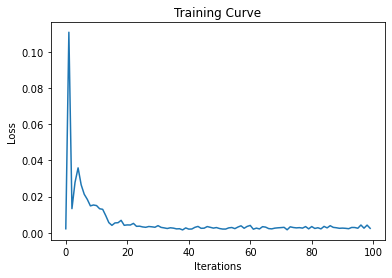

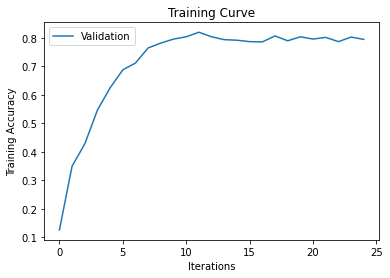

Final Validation Accuracy: 0.795
starting training
epoch:  0
Epoch 0: |Validation acc: 0.616
epoch:  1
Epoch 1: |Validation acc: 0.719
epoch:  2
Epoch 2: |Validation acc: 0.712
epoch:  3
Epoch 3: |Validation acc: 0.756
epoch:  4
Epoch 4: |Validation acc: 0.771
epoch:  5
Epoch 5: |Validation acc: 0.774
epoch:  6
Epoch 6: |Validation acc: 0.756
epoch:  7
Epoch 7: |Validation acc: 0.743
epoch:  8
Epoch 8: |Validation acc: 0.786
epoch:  9
Epoch 9: |Validation acc: 0.775
epoch:  10
Epoch 10: |Validation acc: 0.783
epoch:  11
Epoch 11: |Validation acc: 0.753
epoch:  12
Epoch 12: |Validation acc: 0.773
epoch:  13
Epoch 13: |Validation acc: 0.772
epoch:  14
Epoch 14: |Validation acc: 0.789
epoch:  15
Epoch 15: |Validation acc: 0.77
epoch:  16
Epoch 16: |Validation acc: 0.782
epoch:  17
Epoch 17: |Validation acc: 0.777
epoch:  18
Epoch 18: |Validation acc: 0.792
epoch:  19
Epoch 19: |Validation acc: 0.775
epoch:  20
Epoch 20: |Validation acc: 0.788
epoch:  21
Epoch 21: |Validation acc: 0.795
ep

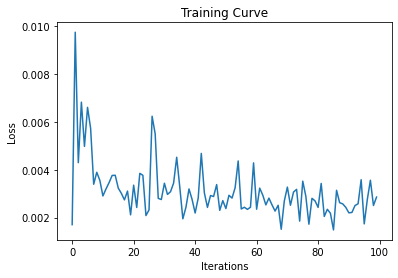

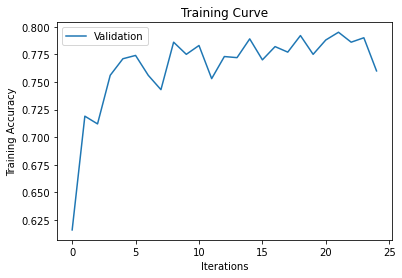

Final Validation Accuracy: 0.76
starting training
epoch:  0
Epoch 0: |Validation acc: 0.822
epoch:  1
Epoch 1: |Validation acc: 0.79
epoch:  2
Epoch 2: |Validation acc: 0.814
epoch:  3
Epoch 3: |Validation acc: 0.821
epoch:  4
Epoch 4: |Validation acc: 0.826
epoch:  5
Epoch 5: |Validation acc: 0.813
epoch:  6
Epoch 6: |Validation acc: 0.821
epoch:  7
Epoch 7: |Validation acc: 0.83
epoch:  8
Epoch 8: |Validation acc: 0.816
epoch:  9
Epoch 9: |Validation acc: 0.818
epoch:  10
Epoch 10: |Validation acc: 0.814
epoch:  11
Epoch 11: |Validation acc: 0.809
epoch:  12
Epoch 12: |Validation acc: 0.811
epoch:  13
Epoch 13: |Validation acc: 0.823
epoch:  14
Epoch 14: |Validation acc: 0.83
epoch:  15
Epoch 15: |Validation acc: 0.824
epoch:  16
Epoch 16: |Validation acc: 0.824
epoch:  17
Epoch 17: |Validation acc: 0.823
epoch:  18
Epoch 18: |Validation acc: 0.814
epoch:  19
Epoch 19: |Validation acc: 0.832
epoch:  20
Epoch 20: |Validation acc: 0.84
epoch:  21
Epoch 21: |Validation acc: 0.823
epoch:

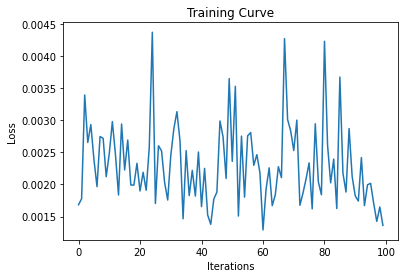

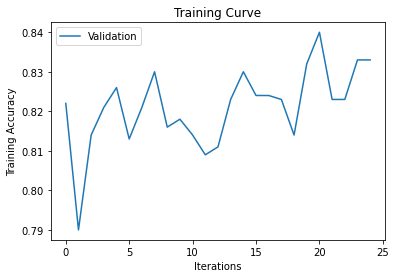

Final Validation Accuracy: 0.833
starting training
epoch:  0
Epoch 0: |Validation acc: 0.823
epoch:  1
Epoch 1: |Validation acc: 0.842
epoch:  2
Epoch 2: |Validation acc: 0.835
epoch:  3
Epoch 3: |Validation acc: 0.829
epoch:  4
Epoch 4: |Validation acc: 0.828
epoch:  5
Epoch 5: |Validation acc: 0.835
epoch:  6
Epoch 6: |Validation acc: 0.835
epoch:  7
Epoch 7: |Validation acc: 0.841
epoch:  8
Epoch 8: |Validation acc: 0.844
epoch:  9
Epoch 9: |Validation acc: 0.828
epoch:  10
Epoch 10: |Validation acc: 0.824
epoch:  11
Epoch 11: |Validation acc: 0.826
epoch:  12
Epoch 12: |Validation acc: 0.846
epoch:  13
Epoch 13: |Validation acc: 0.849
epoch:  14
Epoch 14: |Validation acc: 0.842
epoch:  15
Epoch 15: |Validation acc: 0.847
epoch:  16
Epoch 16: |Validation acc: 0.832
epoch:  17
Epoch 17: |Validation acc: 0.83
epoch:  18
Epoch 18: |Validation acc: 0.839
epoch:  19
Epoch 19: |Validation acc: 0.838
epoch:  20
Epoch 20: |Validation acc: 0.84
epoch:  21
Epoch 21: |Validation acc: 0.839
epo

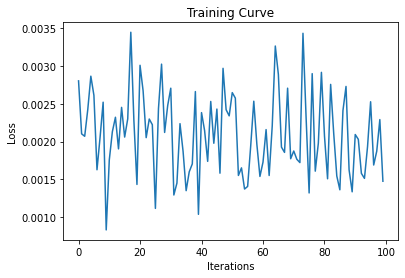

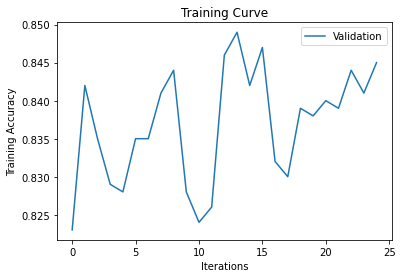

Final Validation Accuracy: 0.845
starting training
epoch:  0
Epoch 0: |Validation acc: 0.839
epoch:  1
Epoch 1: |Validation acc: 0.83
epoch:  2
Epoch 2: |Validation acc: 0.831
epoch:  3
Epoch 3: |Validation acc: 0.835
epoch:  4
Epoch 4: |Validation acc: 0.841
epoch:  5
Epoch 5: |Validation acc: 0.844
epoch:  6
Epoch 6: |Validation acc: 0.849
epoch:  7
Epoch 7: |Validation acc: 0.843
epoch:  8
Epoch 8: |Validation acc: 0.847
epoch:  9
Epoch 9: |Validation acc: 0.851
epoch:  10
Epoch 10: |Validation acc: 0.853
epoch:  11
Epoch 11: |Validation acc: 0.855
epoch:  12
Epoch 12: |Validation acc: 0.857
epoch:  13
Epoch 13: |Validation acc: 0.866
epoch:  14
Epoch 14: |Validation acc: 0.857
epoch:  15
Epoch 15: |Validation acc: 0.852
epoch:  16
Epoch 16: |Validation acc: 0.851
epoch:  17
Epoch 17: |Validation acc: 0.848
epoch:  18
Epoch 18: |Validation acc: 0.855
epoch:  19
Epoch 19: |Validation acc: 0.85
epoch:  20
Epoch 20: |Validation acc: 0.848
epoch:  21
Epoch 21: |Validation acc: 0.857
epo

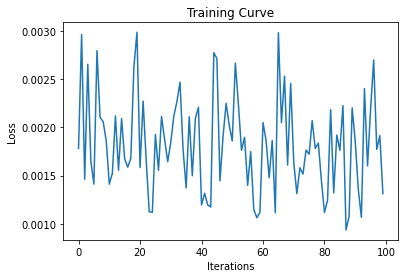

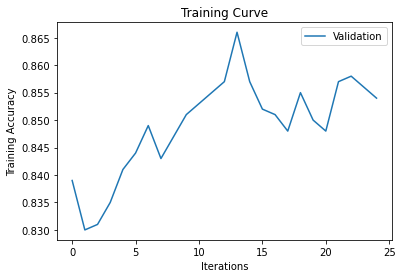

Final Validation Accuracy: 0.854
starting training
epoch:  0
Epoch 0: |Validation acc: 0.852
epoch:  1
Epoch 1: |Validation acc: 0.851
epoch:  2
Epoch 2: |Validation acc: 0.86
epoch:  3
Epoch 3: |Validation acc: 0.855
epoch:  4
Epoch 4: |Validation acc: 0.858
epoch:  5
Epoch 5: |Validation acc: 0.857
epoch:  6
Epoch 6: |Validation acc: 0.865
epoch:  7
Epoch 7: |Validation acc: 0.856
epoch:  8
Epoch 8: |Validation acc: 0.858
epoch:  9
Epoch 9: |Validation acc: 0.859
epoch:  10
Epoch 10: |Validation acc: 0.857
epoch:  11
Epoch 11: |Validation acc: 0.859
epoch:  12
Epoch 12: |Validation acc: 0.857
epoch:  13
Epoch 13: |Validation acc: 0.856
epoch:  14
Epoch 14: |Validation acc: 0.862
epoch:  15
Epoch 15: |Validation acc: 0.861
epoch:  16
Epoch 16: |Validation acc: 0.861
epoch:  17
Epoch 17: |Validation acc: 0.861
epoch:  18
Epoch 18: |Validation acc: 0.861
epoch:  19
Epoch 19: |Validation acc: 0.859
epoch:  20
Epoch 20: |Validation acc: 0.858
epoch:  21
Epoch 21: |Validation acc: 0.859
ep

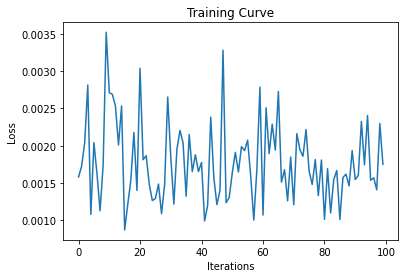

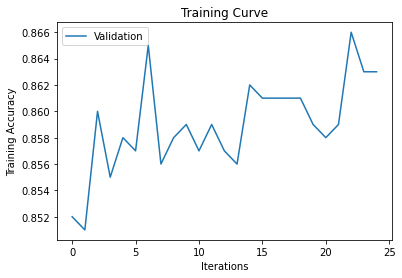

Final Validation Accuracy: 0.863
starting training
epoch:  0
Epoch 0: |Validation acc: 0.864
epoch:  1
Epoch 1: |Validation acc: 0.863
epoch:  2
Epoch 2: |Validation acc: 0.857
epoch:  3
Epoch 3: |Validation acc: 0.86
epoch:  4
Epoch 4: |Validation acc: 0.859
epoch:  5
Epoch 5: |Validation acc: 0.866
epoch:  6
Epoch 6: |Validation acc: 0.872
epoch:  7
Epoch 7: |Validation acc: 0.864
epoch:  8
Epoch 8: |Validation acc: 0.866
epoch:  9
Epoch 9: |Validation acc: 0.864
epoch:  10
Epoch 10: |Validation acc: 0.865
epoch:  11
Epoch 11: |Validation acc: 0.866
epoch:  12
Epoch 12: |Validation acc: 0.864
epoch:  13
Epoch 13: |Validation acc: 0.868
epoch:  14
Epoch 14: |Validation acc: 0.866
epoch:  15
Epoch 15: |Validation acc: 0.867
epoch:  16
Epoch 16: |Validation acc: 0.872
epoch:  17
Epoch 17: |Validation acc: 0.866
epoch:  18
Epoch 18: |Validation acc: 0.867
epoch:  19
Epoch 19: |Validation acc: 0.866
epoch:  20
Epoch 20: |Validation acc: 0.866
epoch:  21
Epoch 21: |Validation acc: 0.866
ep

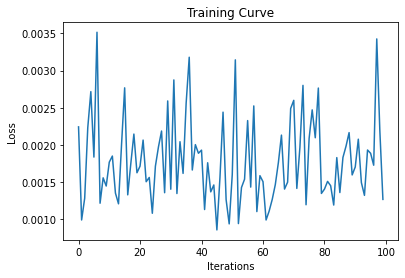

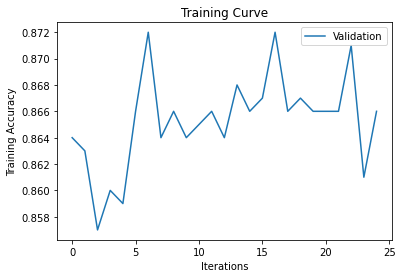

Final Validation Accuracy: 0.866
starting training
epoch:  0
Epoch 0: |Validation acc: 0.86
epoch:  1
Epoch 1: |Validation acc: 0.864
epoch:  2
Epoch 2: |Validation acc: 0.865
epoch:  3
Epoch 3: |Validation acc: 0.871
epoch:  4
Epoch 4: |Validation acc: 0.864
epoch:  5
Epoch 5: |Validation acc: 0.867
epoch:  6
Epoch 6: |Validation acc: 0.867
epoch:  7
Epoch 7: |Validation acc: 0.868
epoch:  8
Epoch 8: |Validation acc: 0.869
epoch:  9
Epoch 9: |Validation acc: 0.865
epoch:  10
Epoch 10: |Validation acc: 0.864
epoch:  11
Epoch 11: |Validation acc: 0.87
epoch:  12
Epoch 12: |Validation acc: 0.864
epoch:  13
Epoch 13: |Validation acc: 0.869
epoch:  14
Epoch 14: |Validation acc: 0.864
epoch:  15
Epoch 15: |Validation acc: 0.87
epoch:  16
Epoch 16: |Validation acc: 0.867
epoch:  17
Epoch 17: |Validation acc: 0.866
epoch:  18
Epoch 18: |Validation acc: 0.871
epoch:  19
Epoch 19: |Validation acc: 0.866
epoch:  20
Epoch 20: |Validation acc: 0.866
epoch:  21
Epoch 21: |Validation acc: 0.867
epoc

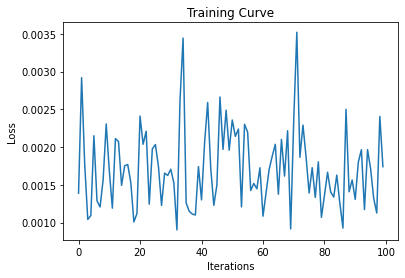

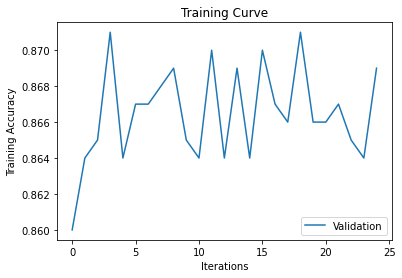

Final Validation Accuracy: 0.869
starting training
epoch:  0
Epoch 0: |Validation acc: 0.863
epoch:  1
Epoch 1: |Validation acc: 0.87
epoch:  2
Epoch 2: |Validation acc: 0.865
epoch:  3
Epoch 3: |Validation acc: 0.868
epoch:  4
Epoch 4: |Validation acc: 0.866
epoch:  5
Epoch 5: |Validation acc: 0.869
epoch:  6
Epoch 6: |Validation acc: 0.868
epoch:  7
Epoch 7: |Validation acc: 0.866
epoch:  8
Epoch 8: |Validation acc: 0.865
epoch:  9
Epoch 9: |Validation acc: 0.863
epoch:  10
Epoch 10: |Validation acc: 0.868
epoch:  11
Epoch 11: |Validation acc: 0.871
epoch:  12
Epoch 12: |Validation acc: 0.871
epoch:  13
Epoch 13: |Validation acc: 0.868
epoch:  14
Epoch 14: |Validation acc: 0.87
epoch:  15
Epoch 15: |Validation acc: 0.866
epoch:  16
Epoch 16: |Validation acc: 0.868
epoch:  17
Epoch 17: |Validation acc: 0.868
epoch:  18
Epoch 18: |Validation acc: 0.867
epoch:  19
Epoch 19: |Validation acc: 0.868
epoch:  20
Epoch 20: |Validation acc: 0.872
epoch:  21
Epoch 21: |Validation acc: 0.869
epo

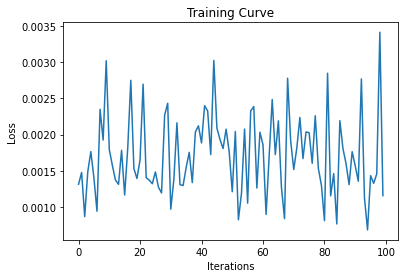

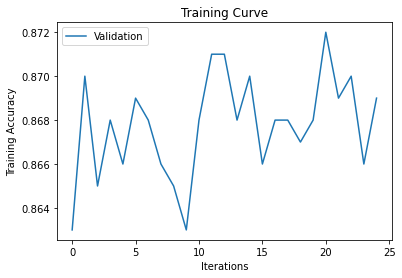

Final Validation Accuracy: 0.869
starting training
epoch:  0
Epoch 0: |Validation acc: 0.866
epoch:  1
Epoch 1: |Validation acc: 0.867
epoch:  2
Epoch 2: |Validation acc: 0.867
epoch:  3
Epoch 3: |Validation acc: 0.866
epoch:  4
Epoch 4: |Validation acc: 0.862
epoch:  5
Epoch 5: |Validation acc: 0.868
epoch:  6
Epoch 6: |Validation acc: 0.87
epoch:  7
Epoch 7: |Validation acc: 0.867
epoch:  8
Epoch 8: |Validation acc: 0.868
epoch:  9
Epoch 9: |Validation acc: 0.864
epoch:  10
Epoch 10: |Validation acc: 0.866
epoch:  11
Epoch 11: |Validation acc: 0.865
epoch:  12
Epoch 12: |Validation acc: 0.866
epoch:  13
Epoch 13: |Validation acc: 0.865
epoch:  14
Epoch 14: |Validation acc: 0.867
epoch:  15
Epoch 15: |Validation acc: 0.87
epoch:  16
Epoch 16: |Validation acc: 0.865
epoch:  17
Epoch 17: |Validation acc: 0.865
epoch:  18
Epoch 18: |Validation acc: 0.863
epoch:  19
Epoch 19: |Validation acc: 0.866
epoch:  20
Epoch 20: |Validation acc: 0.87
epoch:  21
Epoch 21: |Validation acc: 0.869
epoc

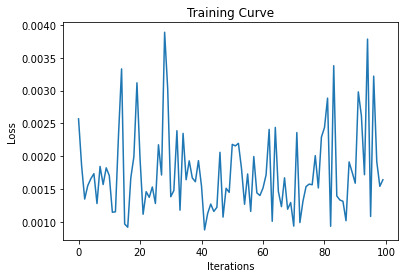

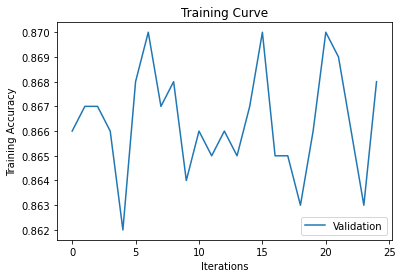

Final Validation Accuracy: 0.868


In [17]:
train(model2, TbiggerSet, batch_size=256, num_epochs=25, learning_rate=0.0007)
train(model2, TbiggerSet, batch_size=256, num_epochs=25, learning_rate=0.0004)
train(model2, TbiggerSet, batch_size=256, num_epochs=25, learning_rate=0.0001)
train(model2, TbiggerSet, batch_size=256, num_epochs=25, learning_rate=0.00007)
train(model2, TbiggerSet, batch_size=256, num_epochs=25, learning_rate=0.00004)
train(model2, TbiggerSet, batch_size=256, num_epochs=25, learning_rate=0.00001)
train(model2, TbiggerSet, batch_size=256, num_epochs=25, learning_rate=0.000007)
train(model2, TbiggerSet, batch_size=256, num_epochs=25, learning_rate=0.000004)
train(model2, TbiggerSet, batch_size=256, num_epochs=25, learning_rate=0.000001)
train(model2, TbiggerSet, batch_size=256, num_epochs=25, learning_rate=0.0000007)

## Memory Diagnosis code

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        profile_memory=True, record_shapes=True) as prof:
  try:
    train(model2, TbiggerSet, batch_size=64, num_epochs=200, learning_rate=0.001)
  except RuntimeError:
    print(":(")
  import gc; gc.collect()
  torch.cuda.empty_cache()

In [ ]:
prof.export_chrome_trace("trace.json")
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=10))

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

In [ ]:
import torch
torch.cuda.max_memory_allocated()

In [ ]:
print(torch.cuda.memory_summary())